# Vecteurs denses avec LSA

## Méthodes

Dans ce notebook nous présentons une des méthodes traditionnelles pour l'obtention de vecteurs denses LSA. Il existe d'autres méthodes disponibles dans [sklearn.decomposition](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.decomposition), notamment:

[Principal Component Analysis (PCA)](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA)

[Non-Negative Matrix Factorization (NMF)](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html#sklearn.decomposition.NMF)

## Analyse sémantique latente (Latent Semantic Analysis)

Technique de réduction de dimension qui se base sur la technique d'algèbre linéaire SVD (truncated singular value decomposition).

Pour toute matrice de nombres réels A de dimension (m n), il existe une factorisation en matrices T, S, D telles que: 

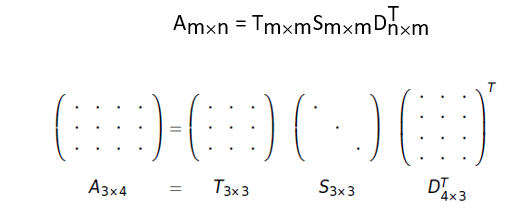

In [3]:
import numpy as np
import os
import pandas as pd
import scipy.stats

### Intuition
Nous avons une matrice terme X document.

Génial et Fantastique n'apparaissent jamais dans le même document et sont tous les deux positifs. Toutefois ils cooccurrent tous les deux avec impressionant. Pouvons-nous faire en sorte de trouver cette notion abstraite de cooccurrence avec de la réduction de dimensionnalité et plus précisément LSA? 

In [17]:
df = pd.DataFrame(
    np.array([
        [1,0,1,0,0,0],
        [0,1,0,1,0,0],
        [1,1,1,1,0,0],
        [0,0,0,0,1,1],
        [0,0,0,0,0,1]], dtype='float64'),
    index=['génial', 'fantastisque', 'impressionant', 'mauvais', 'terrible'])


df

0    1    2    3    4    5
génial         1.0  0.0  1.0  0.0  0.0  0.0
fantastisque   0.0  1.0  0.0  1.0  0.0  0.0
impressionant  1.0  1.0  1.0  1.0  0.0  0.0
mauvais        0.0  0.0  0.0  0.0  1.0  1.0
terrible       0.0  0.0  0.0  0.0  0.0  1.0

In [18]:

def cosinus(u, v):
    return scipy.spatial.distance.cosine(u, v)

In [19]:
def voisins(df, mot, distm=cosinus):
    """
    Recherche les mots les plus similaires (ligne par ligne) au mot en paramètre dans df en se basant sur
    la métrique de distance `distm`.

    Paramètres
       df : pd.DataFrame - l'espace de vecteurs
       mot : le mot
       distm: une fonction permettant de calculer la distance entre des vecteurs 1d 
       et retourner un float

    Retourne
    -------
    pd.Series: liste de mots ordonnée par proximité au mot en paramètre 
    """
    if mot not in df.index:
        raise ValueError('{} ne se retrouve pas dans le vocabulaire de ce modèle'.format(mot))
    w = df.loc[mot]
    distance = df.apply(lambda x: distm(w, x), axis=1)
    return distance.sort_values()


In [20]:
voisins(df, 'génial')

génial           0.000000
impressionant    0.292893
fantastisque     1.000000
mauvais          1.000000
terrible         1.000000
dtype: float64

On constate que la fréquence de cooccurrence ne permet pas de rendre fantastique voisin des autres mots "positifs". Voyons si PPMI règle le problème.

In [21]:
def expected(df):
    sumcol = df.sum(axis=0)
    total = sumcol.sum()
    sumrow = df.sum(axis=1)
    expected = np.outer(sumrow, sumcol) / total
    return df / expected

In [22]:
def ppmi(df):
    df = expected(df)
    with np.errstate(divide='ignore'):
        df = np.log2(df)
    df[np.isinf(df)] = 0.0  
    df[df < 0] = 0.0
    return df

In [23]:
voisins(ppmi(df), 'génial')

génial           0.000000
impressionant    0.292893
fantastisque     1.000000
mauvais          1.000000
terrible         1.000000
dtype: float64

On voit que génial et fantastique ont une cooccurrence avec impressionant et aucune avec les deux autres mots "négatifs". On voit donc qu'ils devraient être plus proches dans l'espace et donc plus similaires que ce que l'on obtient avec la fréquence ou PMI. 
Voyons si LSA règle le problème.

In [24]:
import sklearn.decomposition as skd

svd = skd.TruncatedSVD(n_components=2, n_iter=7, random_state=42)
svd.fit(df)
embedding = svd.transform(df)
lsa_df = pd.DataFrame(embedding, index=df.index)
voisins(lsa_df, 'génial')

génial           0.0
fantastisque     0.0
impressionant    0.0
mauvais          1.0
terrible         1.0
dtype: float64

In [25]:
def lsa(df, k=300):
    """
    df : pd.DataFrame la matrice de dimension mXm
    k : int (defaut: 300) nombre de dimensions
    Retour
    -------
    pd.DataFrame
        la matrice SVD de dimension m X k où m est le nombre de lignes 
        et k est le nombre de colonnes
    """
    row, singvals, col = np.linalg.svd(df, full_matrices=False)
    singvals = np.diag(singvals)
    svdm = np.dot(row[:, 0:k], singvals[0:k, 0:k])
    print('Matrice T')
    print(row[:, 0:k])
    print ('Matrice des valeurs singulières S')
    print (singvals[0:k, 0:k])
    return pd.DataFrame(svdm, index=df.index)

In [26]:
detail_lsa = lsa(df, 2)

Matrice T
[[0.40824829 0.        ]
 [0.40824829 0.        ]
 [0.81649658 0.        ]
 [0.         0.85065081]
 [0.         0.52573111]]
Matrice des valeurs singulières S
[[2.44948974 0.        ]
 [0.         1.61803399]]


In [27]:
voisins(detail_lsa, 'génial')

génial           0.0
fantastisque     0.0
impressionant    0.0
mauvais          1.0
terrible         1.0
dtype: float64

On voit donc que les mots positifs sont donc plus proches dans l'espace avec LSA.